In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [ ]:
#(train_ds, test_ds), ds_info = tfds.load(
  #  'LFW', 
   # as_supervised=True,
   # with_info=True,
   # split=['train[:90%]', 'train[90%:]'],
#)

In [ ]:
n_samples,h,w=lfw_people.images.shape


In [ ]:
X = lfw_people.data
n_features = X.shape[1]
n_features
    

1850

In [ ]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]



In [ ]:
list(target_names)

['Ariel Sharon',
 'Colin Powell',
 'Donald Rumsfeld',
 'George W Bush',
 'Gerhard Schroeder',
 'Hugo Chavez',
 'Tony Blair']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#
#test.shape

In [ ]:
X_train = X_train.reshape(-1, 50, 37, 1).astype(np.float32) / 255.
X_test = X_test.reshape(-1, 50, 37, 1).astype(np.float32) / 255.
X_train.shape


(966, 50, 37, 1)

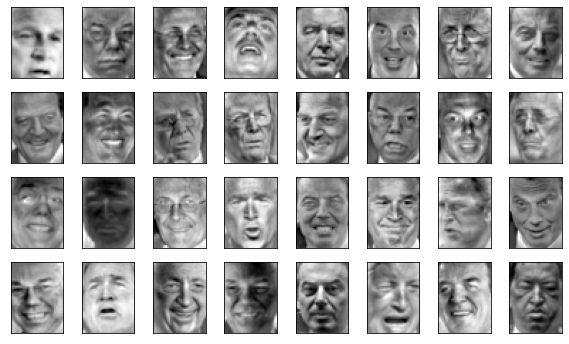

In [ ]:
some_samples = X_train[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#X_train_x = X_train.reshape(-1, 50, 37, 1).astype(np.float32) / 255
#X_test = X_test.reshape(-1, 50, 37, 1).astype(np.float32) / 255

In [ ]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [ ]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 50

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [ ]:
for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 100 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 5.0243964195251465
[100] Loss: 3.4964747428894043
[200] Loss: 2.7758779525756836
[300] Loss: 1.6166976690292358
[400] Loss: 8.728191375732422
[500] Loss: 1.224109411239624
[600] Loss: 5.079863548278809
[700] Loss: 13.164849281311035
[800] Loss: 3.4559922218322754
[900] Loss: 3.670212745666504
[1000] Loss: 12.071159362792969
[1100] Loss: 0.4201856255531311
[1200] Loss: 1.1202061176300049
[1300] Loss: 3.597914218902588
[1400] Loss: 0.668201208114624
[1500] Loss: 1.753978967666626


In [ ]:
test_embs = model(X_test)

In [ ]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [ ]:
X_test_flat = X_test.reshape(-1, 50*37)
X_test_2D = TSNE(n_components=2).fit_transform(X_test_flat[:1000])
labels_for_viz = y_test[:1000]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


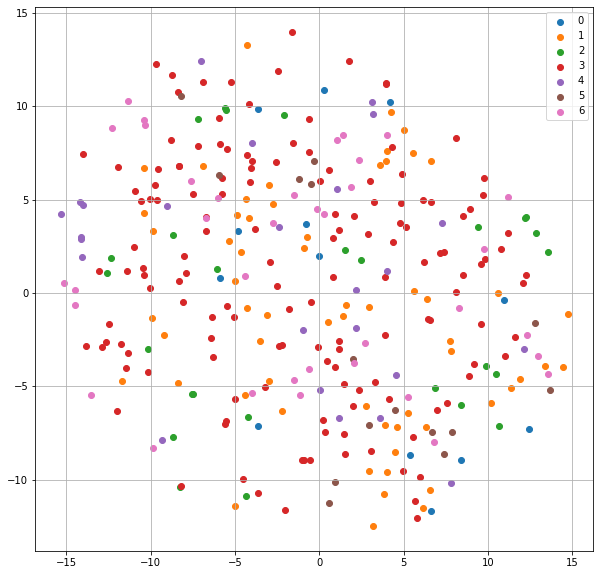

In [ ]:
draw_embeddings(X_test_2D, labels_for_viz, list(range(10)))

In [ ]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = y_test[:1000]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


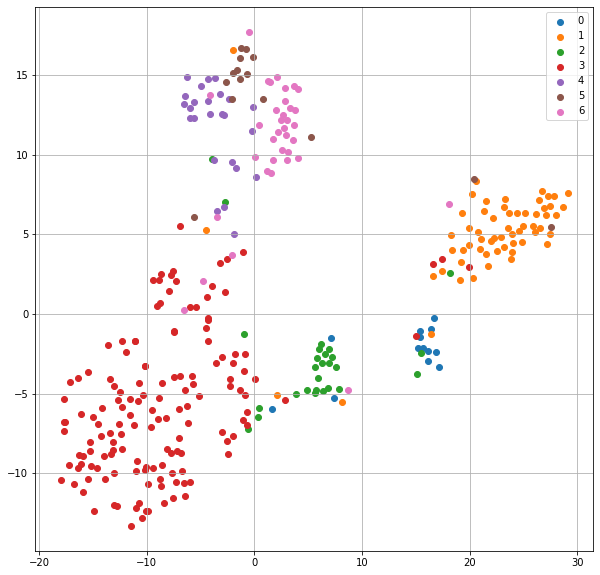

In [ ]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))

In [ ]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (50, 37), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (50, 37, 1))
    return img

img_a1 = load_and_prepare_image('/content/Chaves.png')
img_a2 = load_and_prepare_image('/content/Chaves2.png')
img_b1 = load_and_prepare_image('/content/Bush.png')

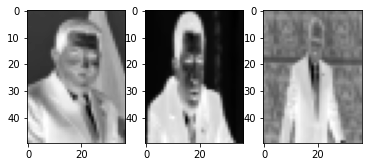

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,0], cmap='gray')
plt.show()

Картинки загружаются ужасного качества, результаты распознавания такие же, не знаю, что с этим делать

In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  97.3578791912858
A2 <-> B1:  124.38675352755614
A1 <-> B1:  134.89628539177792
